## Importing libraries


In [2]:
import os
import cv2
import numpy as np
import string
import pandas as pd
import time
import math
import imutils
import argparse
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from tensorflow.keras.utils import to_categorical


## Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing zip file and checking images

In [3]:

# importing required modules
from zipfile import ZipFile

# specifying the zip file name
img_path = '/content/drive/MyDrive/Image_Captioning_Dataset.zip'

# opening the zip file in READ mode
with ZipFile(img_path, 'r') as zip:
    # printing all the contents of the zip file
    listdir = zip.namelist()

# Now, zip_contents variable contains the list of files and directories in the zip archive
print(listdir[0:10])
print("Total no of images are : " +str(len(listdir)))

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg']
Total no of images are : 8091


## Unzipping images

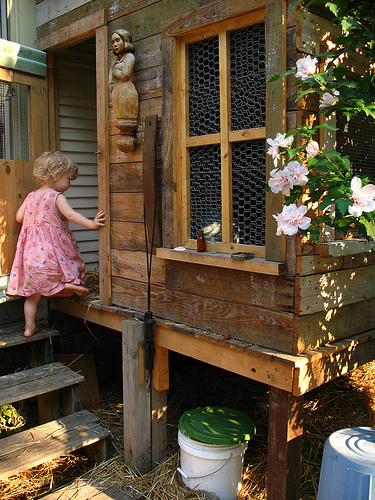

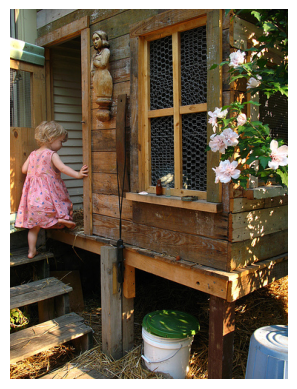

Image saved to: /content/Unzipped_images/1000268201_693b08cb0e.jpg
Total number of files saved: 8091


In [4]:
from zipfile import ZipFile
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab
import matplotlib.pyplot as plt

# Directory to save the unzipped images
output_dir = r'/content/Unzipped_images'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Extract the first image from the zip file
with ZipFile(img_path, 'r') as zip:
    # Assuming the first image is stored in the root directory of the zip file
    first_image_name = zip.namelist()[0]
    with zip.open(first_image_name) as img_file:
        img_data = img_file.read()

# Convert the image data into a numpy array
nparr = np.frombuffer(img_data, np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Save the image to the output directory
output_img_path = os.path.join(output_dir, os.path.basename(first_image_name))
cv2.imwrite(output_img_path, img)

# Display the image using cv2_imshow
cv2_imshow(img)  # Display the image in Colab

# Display the image using Matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis
plt.show()

print("Image saved to:", os.path.abspath(output_img_path))

# Extract all files from the zip file
with ZipFile(img_path, 'r') as zip:
    zip.extractall(output_dir)

# List all files in the output directory
file_names = os.listdir(output_dir)

# Count the number of saved files
num_saved_files = len(file_names)

print("Total number of files saved:", num_saved_files)


## loading resnet


In [5]:
from keras.applications.resnet import ResNet50, preprocess_input
#Load Resnet
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Un comment if you want to see the layers
#print(resnet_model.summary()) # Un comment if you want to see the layers

94765736/94765736 [==============================] - 1s 0us/step


## Extracting features of all images

In [6]:
import os

# Extract features from all the given images
num_images_processed = 0  # Counter to track the number of images processed
final_features = {}
for i, path in enumerate(listdir, 1):
    image_path = os.path.join(output_dir, path)
    if os.path.exists(image_path):
        img_ori = cv2.imread(image_path)
        if img_ori is not None:
            img = cv2.resize(img_ori, (224, 224))
            x = np.expand_dims(img, axis=0)
            x = preprocess_input(x)

            # Use the VGG model for feature generation
            features = resnet_model.predict(x)
            final_features[path] = features.flatten()

            num_images_processed += 1  # Increment the counter

            print(f"{num_images_processed}/{i} images processed")  # Print progress

        else:
            print(f"Failed to read image: {image_path}")
    else:
        print(f"Image not found: {image_path}")

print("Total number of images processed:", len(final_features))
print("Shape of one feature vector:", final_features[listdir[0]].shape)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
5593/5593 images processed
1/1 [==============================] - 0s 22ms/step
5594/5594 images processed
1/1 [==============================] - 0s 21ms/step
5595/5595 images processed
1/1 [==============================] - 0s 23ms/step
5596/5596 images processed
1/1 [==============================] - 0s 22ms/step
5597/5597 images processed
1/1 [==============================] - 0s 25ms/step
5598/5598 images processed
1/1 [==============================] - 0s 22ms/step
5599/5599 images processed
1/1 [==============================] - 0s 24ms/step
5600/5600 images processed
1/1 [==============================] - 0s 21ms/step
5601/5601 images processed
1/1 [==============================] - 0s 22ms/step
5602/5602 images processed
1/1 [==============================] - 0s 23ms/step
5603/5603 images processed
1/1 [==============================] - 0s 25ms/step
5604/5604 images processed
1

## Reading pickle file

In [7]:
# Read the pickle file which contains all the captions for the given image

object = pd.read_pickle(r'/content/setpklfile.pkl')

# Print first five values

object[0:5]

print("Total Count of Captions are : " + str(len(object)))

Total Count of Captions are : 25000


## Mapping images to captions

In [8]:
# Match these 2 files (images and captions) to map images with their corresponding captions
fileCaption = []
fileFeature = []

for i in range(len(object)):
    # Extract file name and caption from caption files
    file_name = object[i].split("\t")[0][:-2]
    file_text = object[i].split("\t")[1]

    for j in final_features.keys():  # Iterate over the keys directly
        # Check if the file_name matches any key in final_features
        if file_name == j:
            fileCaption.append(file_text)
            fileFeature.append(final_features[j])  # Use the key to directly access the feature
            break

# Convert lists to arrays
fileFeature = np.array(fileFeature)

print(fileCaption[0:5])
print(fileFeature.shape)
print(len(fileCaption))

['A man in a black hoodie be hold a paper sign .', 'Three race dog be run out of the start gate on a track .', 'Two motorcycle with two rider each .', 'A man on a bike nest to a river .', 'A football player try tackle another player who have the ball .']
(24996, 2048)
24996


In [9]:
#Add Start and End token for all the captions
temp_lt = []
for i in fileCaption:
    w = '<start> ' + i + ' <end>'
    temp_lt.append(w)
fileCaption = temp_lt.copy()

print(fileCaption[0:5])

['<start> A man in a black hoodie be hold a paper sign . <end>', '<start> Three race dog be run out of the start gate on a track . <end>', '<start> Two motorcycle with two rider each . <end>', '<start> A man on a bike nest to a river . <end>', '<start> A football player try tackle another player who have the ball . <end>']


## Tokenizing and padding all sentences

In [10]:
#Tokenize all the sentences
def tokenize(sentences):
    """
    This function will also save the tokeniser to convert ID's back to the text.
    """
    # Create tokenizer
    text_tokenizer = Tokenizer()
    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

text_tokenized, text_tokenizer = tokenize(fileCaption)

print(text_tokenized[0:5])

total_vocab = len(text_tokenizer.word_index) + 1
max_sentence_len = int(len(max(text_tokenized, key=len)))

print('Maximum length of sentence is : {}'.format(len(max(text_tokenized, key=len))))
print("Total vocabulary is of {} unique words".format(total_vocab))

#Pad all the tokenized sentences with "0" to make all the sentences of the same Length
pad_sentence = pad_sequences(text_tokenized, max_sentence_len, padding = "post")
pad_sentence[0:5]

# Reshape padded sentences (The input for LSTMs must be three dimensional.)
pad_sentence = pad_sentence.reshape(*pad_sentence.shape, 1)

print("Shape of the padded sentences is : " + str(pad_sentence.shape))

print(pad_sentence[0])

[[3, 1, 10, 4, 1, 19, 796, 5, 39, 1, 431, 189, 2], [3, 50, 102, 8, 5, 21, 89, 12, 7, 3, 797, 6, 1, 176, 2], [3, 13, 193, 11, 13, 263, 142, 2], [3, 1, 10, 6, 1, 71, 3200, 24, 1, 225, 2], [3, 1, 122, 63, 185, 453, 73, 63, 237, 93, 7, 41, 2]]
Maximum length of sentence is : 35
Total vocabulary is of 5349 unique words
Shape of the padded sentences is : (24996, 35, 1)
[[  3]
 [  1]
 [ 10]
 [  4]
 [  1]
 [ 19]
 [796]
 [  5]
 [ 39]
 [  1]
 [431]
 [189]
 [  2]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]]


## Train and Test split

In [11]:
from sklearn.model_selection import train_test_split
#Split Train and Test data
X_train, X_test, y_train, y_test = train_test_split(fileFeature, pad_sentence, test_size=0.2, random_state=42)
print("Training VGG Feature Shape is      : " + str(X_train.shape))
print("Testing VGG Feature Shape is       : " + str(X_test.shape))
print("Training Encoded Caption Shape is  : " + str(y_train.shape))
print("Testing Encoded Caption Shape is   : " + str(y_test.shape))

Training VGG Feature Shape is      : (19996, 2048)
Testing VGG Feature Shape is       : (5000, 2048)
Training Encoded Caption Shape is  : (19996, 35, 1)
Testing Encoded Caption Shape is   : (5000, 35, 1)


## Converting input data into tensors

In [12]:
# Now we need to convert input data to tensors so that tensorflow can consume this.
def convert_to_tensors(x, y, batch_size):
    data_tensor = tf.data.Dataset.from_tensor_slices((x, y))
    data_tensor = data_tensor.cache()
    data_tensor = data_tensor.shuffle(2048, reshuffle_each_iteration = True)
    data_tensor = data_tensor.batch(batch_size, drop_remainder = True)
    return data_tensor

batch_size = 128
train = convert_to_tensors(X_train, y_train, batch_size)
test = convert_to_tensors(X_test, y_test, batch_size)

# Building Resnet model(CNN) with LSTM(RNN)

In [13]:
# Build model architecture

input_sequence = Input(shape=(2048,))

# In order to have this same vector (VGG Input Feature) for every time step we need to use the layer "RepeatVector"
r_vec = RepeatVector(max_sentence_len)(input_sequence)

"""
The Dropout layer is placed below the first LSTM layer because we need to decrease
the number of trainable parameters and the first LSTM layer has the highest amount
of parameters.
"""
decoder1 = LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(), dropout=0.2)(r_vec)
decoder2 = LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2())(decoder1)
decoder3 = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2())(decoder2)

"""
We are using return_sequence=True in LSTM layer so LSTM layer outputs a vector at every time step,
so we need to apply the Dense layer at every time step and predict one word at a time at every time step.
For that purpose we are using keras TimeDistributed layer, which applies the same Dense layer to every
time step.
"""
logits = TimeDistributed(Dense(total_vocab))(decoder3)

## Model compilation

In [14]:
#Compile the model and run
lr_rate = 1e-3
model = Model(input_sequence, Activation('softmax')(logits))
model.compile(loss=sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 repeat_vector (RepeatVecto  (None, 35, 2048)          0         
 r)                                                              
                                                                 
 lstm (LSTM)                 (None, 35, 256)           2360320   
                                                                 
 lstm_1 (LSTM)               (None, 35, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 35, 64)            49408     
                                                                 
 time_distributed (TimeDist  (None, 35, 5349)          347685    
 ributed)                                                    

## Model evaluation

Iteration 1- best accuracy

In [15]:

t0 = time.time()
ht = model.fit(train,
               validation_data=test,
               epochs=10,
               shuffle=True,
               verbose=1)
t1 = time.time()

print("Print the total time taken for training", round(t1-t0,3),"seconds")

#The Loss and Accuracy of Test Data is (Plot the graph)
Loss, accuracy = model.evaluate(test, verbose=2)

print("Loss: ", Loss)
print("Accuracy: ", accuracy)

Epoch 1/10
156/156 [==============================] - 15s 55ms/step - loss: 5.9078 - accuracy: 0.6301 - val_loss: 2.5839 - val_accuracy: 0.6358
Epoch 2/10
156/156 [==============================] - 7s 47ms/step - loss: 2.2972 - accuracy: 0.6663 - val_loss: 2.1247 - val_accuracy: 0.6786
Epoch 3/10
156/156 [==============================] - 7s 46ms/step - loss: 2.0431 - accuracy: 0.6764 - val_loss: 1.9521 - val_accuracy: 0.6839
Epoch 4/10
156/156 [==============================] - 7s 47ms/step - loss: 1.9335 - accuracy: 0.6949 - val_loss: 1.8837 - val_accuracy: 0.6978
Epoch 5/10
156/156 [==============================] - 8s 49ms/step - loss: 1.8765 - accuracy: 0.6957 - val_loss: 1.8390 - val_accuracy: 0.6980
Epoch 6/10
156/156 [==============================] - 7s 46ms/step - loss: 1.8413 - accuracy: 0.6958 - val_loss: 1.8108 - val_accuracy: 0.7020
Epoch 7/10
156/156 [==============================] - 7s 46ms/step - loss: 1.8174 - accuracy: 0.7018 - val_loss: 1.7935 - val_accuracy: 0.704

Iteration 2


In [16]:
lr_rate = 1e-4

t0 = time.time()
ht = model.fit(train,
               validation_data=test,
               epochs=10,
               shuffle=True,
               verbose=1)
t1 = time.time()

print("Print the total time taken for training", round(t1-t0,3),"seconds")

#The Loss and Accuracy of Test Data is (Plot the graph)
Loss, accuracy = model.evaluate(test, verbose=2)

print("Loss: ", Loss)
print("Accuracy: ", accuracy)

Epoch 1/10
156/156 [==============================] - 8s 49ms/step - loss: 1.7855 - accuracy: 0.7024 - val_loss: 1.7732 - val_accuracy: 0.7047
Epoch 2/10
156/156 [==============================] - 7s 46ms/step - loss: 1.7828 - accuracy: 0.7024 - val_loss: 1.7710 - val_accuracy: 0.7047
Epoch 3/10
156/156 [==============================] - 7s 47ms/step - loss: 1.7801 - accuracy: 0.7023 - val_loss: 1.7719 - val_accuracy: 0.7047
Epoch 4/10
156/156 [==============================] - 8s 49ms/step - loss: 1.7779 - accuracy: 0.7022 - val_loss: 1.7685 - val_accuracy: 0.7046
Epoch 5/10
156/156 [==============================] - 7s 47ms/step - loss: 1.7764 - accuracy: 0.7023 - val_loss: 1.7675 - val_accuracy: 0.7047
Epoch 6/10
156/156 [==============================] - 8s 49ms/step - loss: 1.7752 - accuracy: 0.7024 - val_loss: 1.7674 - val_accuracy: 0.7046
Epoch 7/10
156/156 [==============================] - 7s 46ms/step - loss: 1.7740 - accuracy: 0.7024 - val_loss: 1.7670 - val_accuracy: 0.7047

Iteration 3

In [39]:
lr_rate = 1e-1

t0 = time.time()
ht = model.fit(train,
               validation_data=test,
               epochs=10,
               shuffle=True,
               verbose=1)
t1 = time.time()

print("Print the total time taken for training", round(t1-t0,3),"seconds")

#The Loss and Accuracy of Test Data is (Plot the graph)
Loss, accuracy = model.evaluate(test, verbose=2)

print("Loss: ", Loss)
print("Accuracy: ", accuracy)

Epoch 1/10
156/156 [==============================] - 8s 50ms/step - loss: 1.7701 - accuracy: 0.7023 - val_loss: 1.7658 - val_accuracy: 0.7048
Epoch 2/10
156/156 [==============================] - 8s 50ms/step - loss: 1.7693 - accuracy: 0.7023 - val_loss: 1.7685 - val_accuracy: 0.7045
Epoch 3/10
156/156 [==============================] - 7s 47ms/step - loss: 1.7692 - accuracy: 0.7023 - val_loss: 1.7667 - val_accuracy: 0.7046
Epoch 4/10
156/156 [==============================] - 7s 46ms/step - loss: 1.7686 - accuracy: 0.7025 - val_loss: 1.7678 - val_accuracy: 0.7047
Epoch 5/10
156/156 [==============================] - 7s 47ms/step - loss: 1.7679 - accuracy: 0.7024 - val_loss: 1.7668 - val_accuracy: 0.7045
Epoch 6/10
156/156 [==============================] - 7s 46ms/step - loss: 1.7668 - accuracy: 0.7024 - val_loss: 1.7663 - val_accuracy: 0.7048
Epoch 7/10
156/156 [==============================] - 7s 46ms/step - loss: 1.7664 - accuracy: 0.7023 - val_loss: 1.7674 - val_accuracy: 0.7048

## Plotting of graphs of loss and accuracy

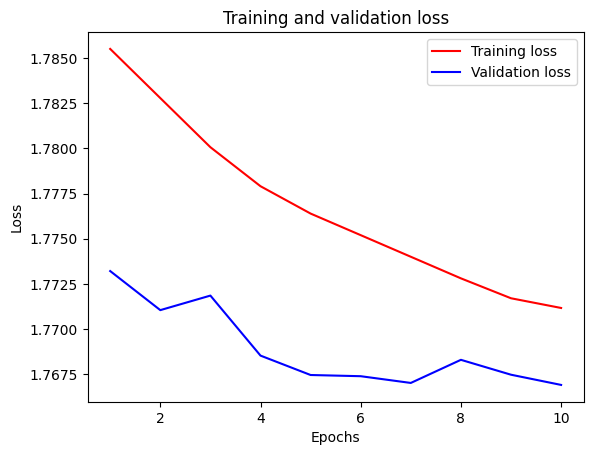

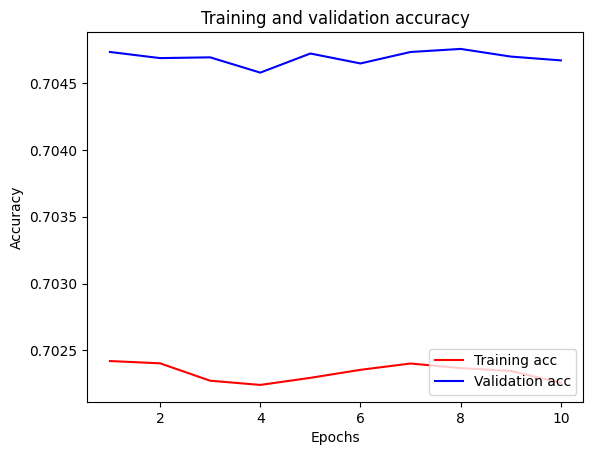

In [17]:
history_dict = ht.history
history_dict.keys()
acc = history_dict['accuracy']
loss = history_dict['loss']
val_acc  = history_dict['val_accuracy']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Generating caption for 5 random images

Image 1

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 1s 925ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


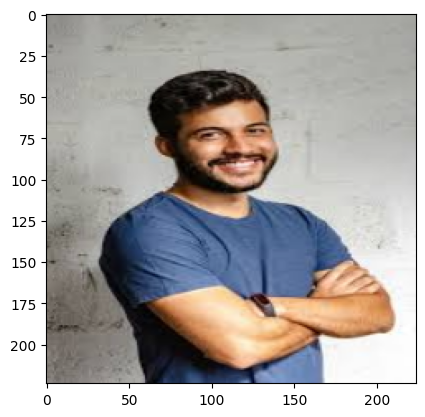

In [18]:
image_path = '/content/images.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))


image 2

1/1 [==============================] - 0s 22ms/step
The predicted sentence is :
1/1 [==============================] - 0s 21ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


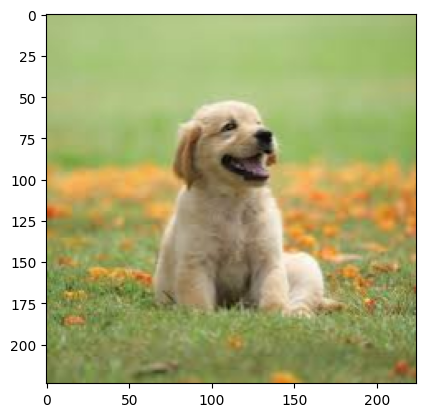

In [19]:
image_path = '/content/dog.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 3

1/1 [==============================] - 0s 48ms/step
The predicted sentence is :
1/1 [==============================] - 0s 19ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


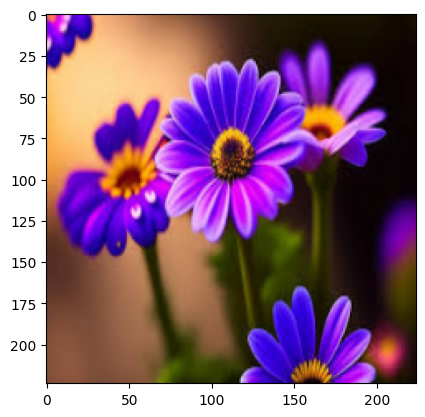

In [20]:
image_path = '/content/flower.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 4

1/1 [==============================] - 0s 24ms/step
The predicted sentence is :
1/1 [==============================] - 0s 20ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


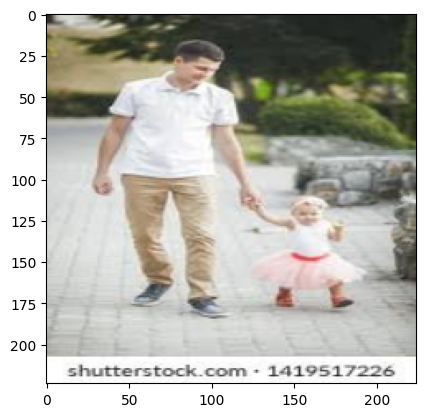

In [21]:
image_path = '/content/man and child.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 5

1/1 [==============================] - 0s 24ms/step
The predicted sentence is :
1/1 [==============================] - 0s 19ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


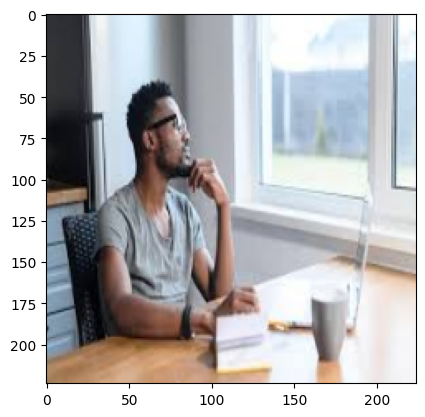

In [22]:
image_path = '/content/man labor.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 6

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 0s 18ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


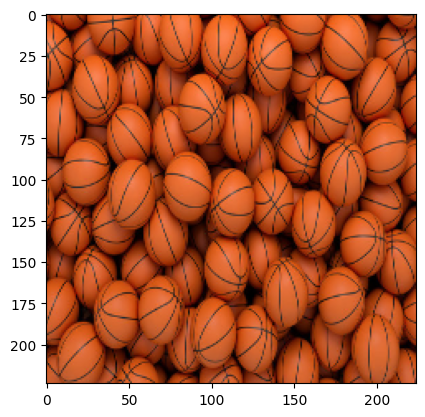

In [23]:
image_path = '/content/basketballs.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 7

1/1 [==============================] - 0s 22ms/step
The predicted sentence is :
1/1 [==============================] - 0s 20ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


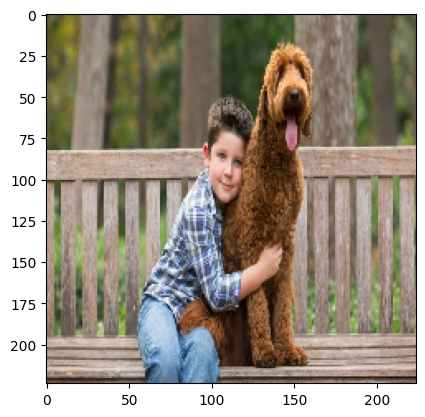

In [24]:
image_path = '/content/boy and dog.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 8

1/1 [==============================] - 0s 54ms/step
The predicted sentence is :
1/1 [==============================] - 0s 31ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


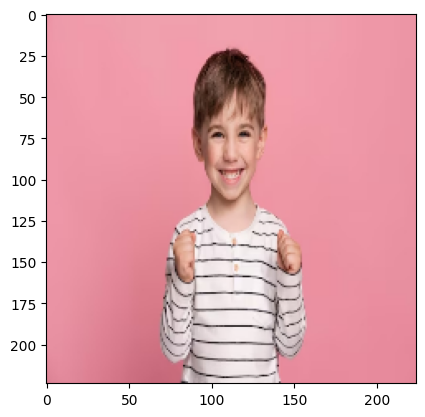

In [29]:
image_path = '/content/boy smiling.jpg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 9

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 0s 19ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


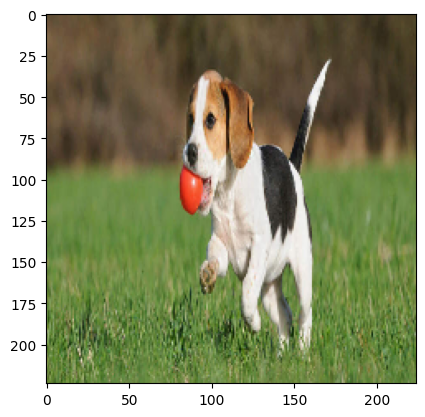

In [31]:
image_path = '/content/dog playing.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 10

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 0s 20ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


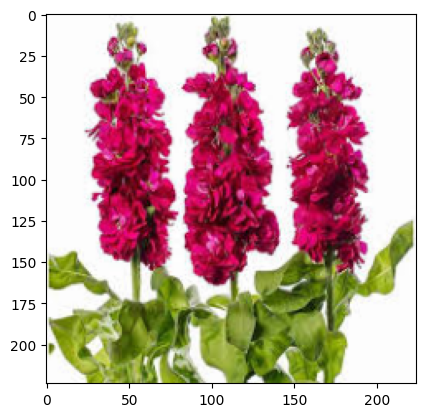

In [32]:
image_path = '/content/flower.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 11

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 0s 19ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


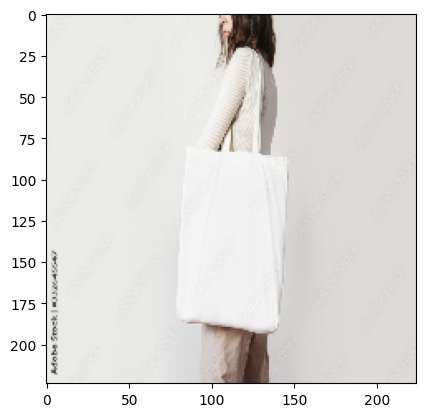

In [33]:
image_path = '/content/girl with totebag.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 12

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 0s 20ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


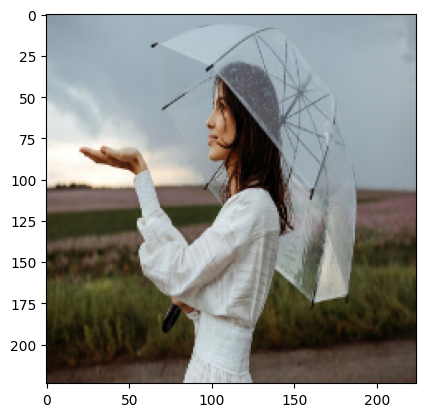

In [34]:
image_path = '/content/girl with umbrella.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 13

1/1 [==============================] - 0s 21ms/step
The predicted sentence is :
1/1 [==============================] - 0s 19ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


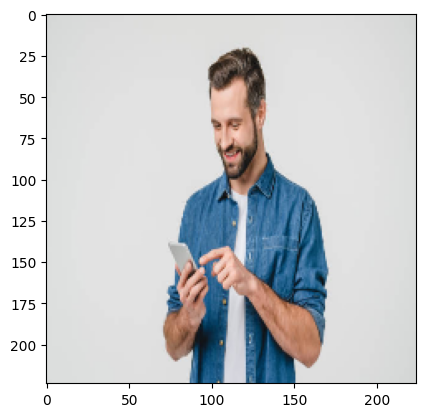

In [35]:
image_path = '/content/man.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 14

1/1 [==============================] - 0s 77ms/step
The predicted sentence is :
1/1 [==============================] - 0s 82ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


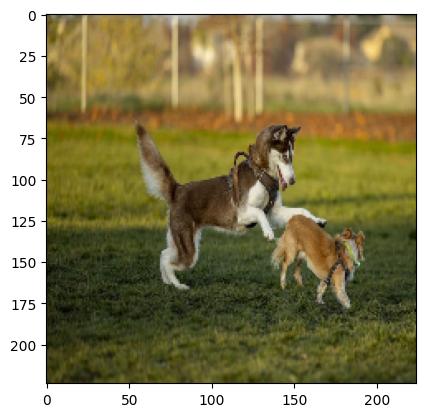

In [37]:
image_path = '/content/two dogs playing.jpg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))

image 15

1/1 [==============================] - 0s 35ms/step
The predicted sentence is :
1/1 [==============================] - 0s 28ms/step
start a man be a a a a <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


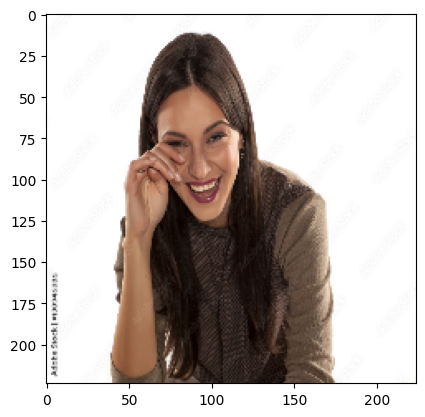

In [38]:
image_path = '/content/woman laughing.jpeg'

img_ori = cv2.imread(image_path)
img = cv2.resize(img_ori, (224, 224))
# Converts a PIL Image to 3D Numy Array
x = image.img_to_array(img)
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature = resnet_model.predict(x)
input_feature = np.array(feature[0]).reshape((1, 2048))

# img = cv2.imread(os.path.join(imgs_path, listdir[8]))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

def logits_to_sentence(logits, tokenizer):
    # print(logits)
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


print('The predicted sentence is :')
print(logits_to_sentence(model.predict(input_feature)[0], text_tokenizer))